In this notebook we will be training a model to predict the label of images. We will use the CIFAR-100 data set. The images in this data set have two levels of labels. The first level, the 'coarse' labels and general labels, while the second level, the 'fine' labels are more granular.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# get the train and test data sets for CIFAR-100
ds_train, ds_info_train = tfds.load('cifar100', split='train', with_info=True)
ds_test, ds_info_test = tfds.load('cifar100', split='test', with_info=True)

Let us get some information about the data sets. We will display the size of the train and test data sets, as well as the different labels:

In [2]:
# get the size of the traing set
training_size = ds_train.reduce(0, lambda x, _: x+1).numpy()
# get the size of the test set
test_size = ds_test.reduce(0, lambda x, _: x+1).numpy()
print('There are '+ str(training_size) +' images in the training set')
print('There are '+ str(test_size) +' images in the test set')

# get the label names
class_names = ds_info_train.features['label'].names
coarse_class_names = ds_info_train.features['coarse_label'].names

print('There are ' + str(len(class_names)) + ' fine labels')
print('There are ' + str(len(coarse_class_names)) + ' coarse labels')

# get the shape of the image in the train set
print(ds_train.element_spec['image'].shape)

There are 50000 images in the training set
There are 10000 images in the test set
There are 100 fine labels
There are 20 coarse labels
(32, 32, 3)


The train set has 50,000 images while the test set has 10,000 images. We also see that there are 20 coarse labels and 100 fine labels. In this notebook we will try to predict the fine labels since it is a more challenging excercise. Finally, we see that the shape of each image is (32, 32, 3). Terefore, the images are colored images since there are three channels.

Let us look at some images along with their fine labels:

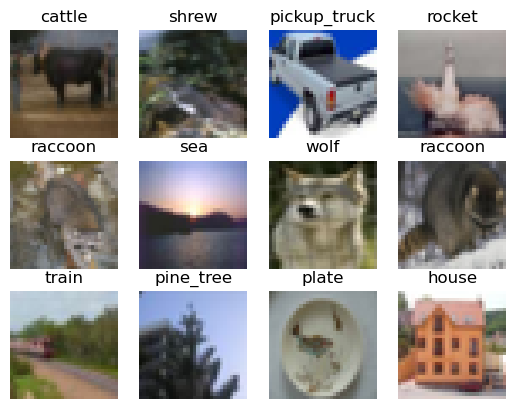

In [3]:
# show images with fine labels
for i, example in enumerate(ds_train.shuffle(1000).take(12)):
    image = example['image']
    label = example['label']
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')
plt.show()

Let us also look at the coarse labels of some images just to have an idea of what they are:

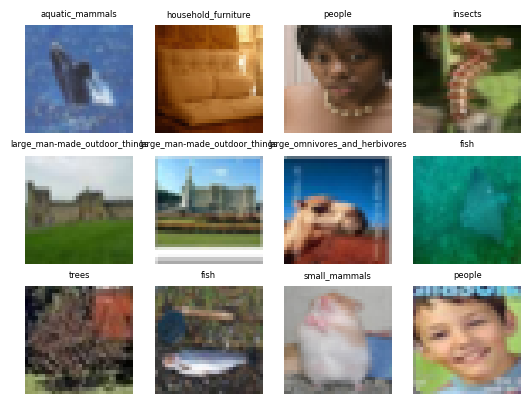

In [4]:
# show images with coarse labels
for i, example in enumerate(ds_train.shuffle(1000).take(12)):
    image = example['image']
    coarse_label = example['coarse_label']
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(coarse_class_names[coarse_label], fontsize = 6)
    plt.axis('off')
plt.show()

We see that the coarse images are more general labels.

Since we want to predict the fine labels, let us create a data set that includes only the images and the fine labels:

In [5]:
def extract_image_and_label(data):
    x = data['image']
    y = data['label']
    return x, y

# get the x and y values for the train and test sets
ds_train_xy = ds_train.map(extract_image_and_label)
# do the same for the test set:
ds_test_xy = ds_test.map(extract_image_and_label)

The first model we are going to build is a simple CNN. We will gradually increase the number of filters as we move deeper into the network whil ereducing the dimensions of the image. We will also use the dropout method as a form of regularization:

In [ ]:
model_1 = keras.Sequential([
    keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='softmax')
])

model_1.summary()

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(ds_train_xy.batch(32), epochs=30)

The accuracy of the model on the train set is XXX. This is not very high, but we can live with it for now. Let us see how well the model performs on the test set:

In [ ]:
model_1.evaluate(ds_test_xy.batch(32))

This is a big drop in accuracy. The model is not performing well on the test set. Let us look at the model predictions on the train set:

In [ ]:
#look at performance on train set
for i, (image, label) in enumerate(ds_train_xy.shuffle(1000).take(3)):
    image_resize = tf.expand_dims(image, 0)
    pred = model_1.predict(image_resize)
    plt.subplot(3, 1, i + 1)
    plt.imshow(image)
    plt.title('Predicted: ' + class_names[np.argmax(pred)] + ', Actual: ' + class_names[label])
    plt.axis('off')
plt.show()

Let us now look at the performce on the test set:

In [ ]:
# look as performance on test set
for i, (image, label) in enumerate(ds_test_xy.shuffle(1000).take(3)):
    image_resize = tf.expand_dims(image, 0)
    pred = model.predict(image_resize)
    plt.subplot(3, 1, i + 1)
    plt.imshow(image)
    plt.title('Predicted: ' + class_names[np.argmax(pred)] + ', Actual: ' + class_names[label])
    plt.axis('off')
plt.show()

We can clearly see that the model is not doing a good job at predicting the fine labels for the test set.

Let us see if we can do something to train a better model. One useful technique when it comes to images is to augment the training set with images that have undergone random changes. This will help make the model more robust to overfitting.

In [ ]:
def augment_image(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_crop(x, size=[32, 32, 3])
    x = tf.image.random_contrast(x, 0.2, 0.5)
    return x, y

The above function does three things. It randomly flips some images, randomly crops some images, and randomly modified the contrast of some images. Let us now create the augmented data set:

In [ ]:
ds_train_augmented = ds_train_xy.map(augment_image)

This augmented data set does not contain the original images, so we will need to combine both the original images and the augmented images:

In [ ]:
ds_train_xy_augmented = ds_train_xy.concatenate(ds_train_augmented)

We can now use this newly created training set to train the model. We will also modify the model in the hope of making it better. We will use both batch normalization and local response normalization after some layers. The new model will be the following:

In [ ]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(32, 3, padding='same', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(32, 3, padding='same'),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same'),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, 3, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='softmax')
])

model_2.summary()

Let us now train this new model using the data set that contains the augmented data:

In [ ]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(ds_train_xy_augmented.batch(32), epochs=30)

We will now evaluate this model against the test set:

In [ ]:
model_2.evaluate(ds_test_xy.batch(32))

This model is doing a better job than the previous one, but the result is still far from ideal. Let us visualize the performance of this model on the test set:

In [ ]:
# look as performance on test set
for i, (image, label) in enumerate(ds_test_xy.shuffle(1000).take(3)):
    image_resize = tf.expand_dims(image, 0)
    pred = model_2.predict(image_resize)
    plt.subplot(3, 1, i + 1)
    plt.imshow(image)
    plt.title('Predicted: ' + class_names[np.argmax(pred)] + ', Actual: ' + class_names[label])
    plt.axis('off')
plt.show()

We can clearly see that there is much room for improvement.

The CNNs we have been using so far are simple. A lot of research has been done into creating CNNs with more complex architectures. One such CNN is called the ResNet. The main idea behind this architecture is that it relies on what is called a residual unit. As can be seen from te image below, a resildual unit consists of two layers (both are convolutional layers). What makes the unit different is that the input that is fed to the first layer is also added to the output of the second layer. Note that in order to add the input to the second layer, the dimensions of the input must be the same as the dimensions of the output of the second layer. If the stride of the two convolution layers is 1, then there is no problem, since the input will stay the same size as it passes through the two convolution layers. But if the stride of one of the convolution layers is more than 1, then the input will have to be fed into a third convolution layer with the same stride in order to make it the same size as the output of the second convolution layer.

![Residual Unit](ResBlock.png)

The ResNet is made up of many residual layers. It is possible to just load the ResNet using the keras package, but I find it a good excercise to try to code the network yourself. This will help you understand what is happening. The following is the code used to create the ResNet (this code is from the book Hands-on Machine Learning by A.G.):

In [ ]:
# Implement ResNet-34
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

The above class defines the residual layer. We create a class for the layer because this will make it easier just to add it to the model as we do to any other layer. Notice that the main layers of the residual layer are two convolution layers, alogm with batch normalization and relu activation. The skip layer on the other hand is created only of the stride of the convolution laye is more than one. In that case, as described previously, we will need to create a layer that will convert the input to the same shape as the output of the second convolution layer before we can add them together. Notice that the filter size of the skip layer is just one. 

Now that we have the class defined, we can just add residual layers to the model:

In [ ]:
model_3 = keras.models.Sequential()
model_3.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding='same', use_bias=False))
model_3.add(keras.layers.BatchNormalization())
model_3.add(keras.layers.Activation('relu'))
model_3.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]:
    strides = 1 if filters == prev_filters else 2
    model_3.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model_3.add(keras.layers.GlobalAveragePooling2D())
model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(100, activation='softmax'))

model_3.summary()

In the above code, we first create a single convoliution layer followed by a max pooling layer. We then start adding the residual units. We add 16 residual units with differing numbers of filters. As you can see the number of filters increases as we move deeper into the network. 

We can now compile and start training this model using the data set that contains the augmented image. Note that the training of this model will take a very long time (on my computer it took just over 24 hours):

In [ ]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(ds_train_xy_augmented.batch(32), epochs=30)

The accuracy of this model on the train set is much higher than the previous two models. But we really care about the accuracy on the test set:

In [ ]:
model_3.evaluate(ds_test_xy.batch(32))

This is a huge improvment. We clearly see how this architecture delivers the best results. This excercise goes to show that using the correct archiecture can take us from mediocre reuslts to vry good results. Let us visualize this performance:

In [ ]:
# look as performance on test set
for i, (image, label) in enumerate(ds_test_xy.shuffle(1000).take(3)):
    image_resize = tf.expand_dims(image, 0)
    pred = model_3.predict(image_resize)
    plt.subplot(3, 1, i + 1)
    plt.imshow(image)
    plt.title('Predicted: ' + class_names[np.argmax(pred)] + ', Actual: ' + class_names[label])
    plt.axis('off')
plt.show()